# Predicting Customer Lifetime Value (CLV) for Retailers

**Customer Lifetime Value (CLV)** is a metric that predicts the total revenue a business can expect from a customer throughout their relationship with the company. It helps businesses understand the long-term value of retaining customers, rather than focusing solely on short-term transactions. CLV considers factors such as purchase frequency, average spend, and the length of time a customer is expected to remain engaged with the brand. By predicting CLV, businesses can make more informed decisions about customer acquisition, retention strategies, and resource allocation, ultimately improving profitability and customer relationships.


This code demonstrates a predictive model to forecast Customer Lifetime Value (CLV) based on historical retail sales data. The model employs **RFM (Recency, Frequency, and Monetary)** metrics, which are calculated for each customer to provide insight into their buying behavior. After preprocessing the data and creating these features, the code splits the dataset into training and testing sets. It then trains a **Linear Regression** model to predict total spend (a proxy for CLV) using features such as frequency of purchases, monetary value, recency of the last purchase, and customer type. The model's performance is evaluated using metrics like **Root Mean Squared Error (RMSE)** and **R² Score**, which provide insight into the model’s accuracy in predicting future customer behavior. Finally, the trained model is saved for future predictions on new customer data.


----

#### Step 1: Import Libraries and Load Dataset
We import the necessary libraries for data manipulation, model training, and evaluation. pandas is used for reading and processing the dataset. train_test_split helps split the data into training and test sets, LinearRegression is the machine learning model, and StandardScaler ensures the features are scaled.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../data/processed/retail_sales_dataset.csv')
data

,Transaction ID,Date,Product Category,Quantity,Price per Unit,Total Amount,Customer ID,Gender,Age,City,Province,Country,Season,is_discount,Customer Type,Total Spend,Product ID
0,1,2023-01-01,Beauty,3,500,1500,CUST045,Female,55,Montreal,Quebec,Canada,Winter,True,New,10525,5
1,2,2023-01-01,Clothing,3,300,900,CUST041,Male,34,Charlottetown,Prince Edward Island,Canada,Winter,True,New,7650,9
2,3,2023-01-01,Clothing,4,300,1200,CUST022,Male,18,Gatineau,Quebec,Canada,Winter,True,New,11785,9
3,4,2023-01-02,Electronics,3,30,90,CUST007,Male,46,Saint John,New Brunswick,Canada,Winter,True,New,4910,12
4,5,2023-01-02,Beauty,1,25,25,CUST044,Female,22,Gatineau,Quebec,Canada,Winter,True,New,8150,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2023-12-29,Beauty,2,300,600,CUST027,Female,38,Kitchener,Ontario,Canada,Winter,True,Returning,4250,4
996,997,2023-12-29,Beauty,3,500,1500,CUST046,Female,20,Calgary,Alberta,Canada,Winter,False,Returning,4380,5
997,998,2023-12-31,Electronics,2,25,50,CUST017,Female,27,Laval,Quebec,Canada,Winter,True,Returning,9755,11
998,999,2024-01-01,Beauty,3,500,1500,CUST033,Female,50,Sydney,Nova Scotia,Canada,Winter,False,Returning,20180,5


#### Step 2: Data Preprocessing and Feature Engineering

We now focus on preparing the data for the model by calculating RFM (Recency, Frequency, and Monetary) metrics, which are essential for predicting customer lifetime value (CLV). We first convert the 'Date' column to datetime format for easier date manipulation.

`Recency` is calculated as the number of days since a customer's last purchase.

`Frequency` is the total number of purchases each customer has made.

`Monetary` is the total amount spent by the customer.

We then merge these metrics into a single DataFrame (rfm) and merge them back into the original dataset.

The `Customer Type` is converted to a numeric format to make it usable for machine learning. Finally, duplicates are removed to ensure we have one row per customer.

In [2]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Feature engineering - Calculate RFM metrics
current_date = data['Date'].max()

# Recency
customer_recency = data.groupby('Customer ID')['Date'].max().reset_index(name='Recency')
customer_recency['Recency'] = (current_date - customer_recency['Recency']).dt.days

# Frequency
customer_freq = data.groupby('Customer ID').size().reset_index(name='Frequency')

# Monetary
customer_monetary = data.groupby('Customer ID')['Total Amount'].sum().reset_index(name='Monetary')

# Merging RFM data
rfm = customer_freq.merge(customer_monetary, on='Customer ID')
rfm = rfm.merge(customer_recency, on='Customer ID')

# Additional features
rfm_data = rfm[['Customer ID', 'Frequency', 'Monetary', 'Recency']]

# Merge back to original dataset
data = data.merge(rfm_data, on='Customer ID', how='left')

# Convert categorical 'Customer Type' to numeric
data['Customer Type'] = data['Customer Type'].astype('category').cat.codes

# Drop duplicates for customer-level data
customer_data = data.drop_duplicates(subset=['Customer ID'])

data

,Transaction ID,Date,Product Category,Quantity,Price per Unit,Total Amount,Customer ID,Gender,Age,City,Province,Country,Season,is_discount,Customer Type,Total Spend,Product ID,Frequency,Monetary,Recency
0,1,2023-01-01,Beauty,3,500,1500,CUST045,Female,55,Montreal,Quebec,Canada,Winter,True,0,10525,5,22,10525,10
1,2,2023-01-01,Clothing,3,300,900,CUST041,Male,34,Charlottetown,Prince Edward Island,Canada,Winter,True,0,7650,9,18,7650,12
2,3,2023-01-01,Clothing,4,300,1200,CUST022,Male,18,Gatineau,Quebec,Canada,Winter,True,0,11785,9,21,11785,18
3,4,2023-01-02,Electronics,3,30,90,CUST007,Male,46,Saint John,New Brunswick,Canada,Winter,True,0,4910,12,11,4910,70
4,5,2023-01-02,Beauty,1,25,25,CUST044,Female,22,Gatineau,Quebec,Canada,Winter,True,0,8150,1,18,8150,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2023-12-29,Beauty,2,300,600,CUST027,Female,38,Kitchener,Ontario,Canada,Winter,True,1,4250,4,15,4250,3
996,997,2023-12-29,Beauty,3,500,1500,CUST046,Female,20,Calgary,Alberta,Canada,Winter,False,1,4380,5,13,4380,3
997,998,2023-12-31,Electronics,2,25,50,CUST017,Female,27,Laval,Quebec,Canada,Winter,True,1,9755,11,21,9755,1
998,999,2024-01-01,Beauty,3,500,1500,CUST033,Female,50,Sydney,Nova Scotia,Canada,Winter,False,1,20180,5,29,20180,0


#### Step 3: Split Train and Test Data

In [3]:
# Select features and target for CLV prediction
X = customer_data[['Frequency', 'Monetary', 'Recency', 'Customer Type']]  # Features
y = customer_data['Total Spend']  # Target (Total Spend as proxy for CLV)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Step 4: Training the Linear Regression Model

We create a LinearRegression model and train it using the scaled training data (X_train_scaled and y_train). The model learns the relationship between the features (like Frequency, Monetary, etc.) and the target variable (Total Spend) based on the training data.


In [4]:
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

#### Step 5: Evaluate the Model

In [5]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

RMSE: 3.1109505246580865e-12
R2 Score: 1.0


**Mean Squared Error (MSE)**: A measure of the average squared difference between the actual values (y_test) and the predicted values (y_pred), where a smaller value indicates better model performance.

**Root Mean Squared Error (RMSE)**: The square root of MSE, providing an error measure in the same units as the target variable. Lower RMSE values indicate better accuracy.

**R2 Score**: This score indicates the proportion of the variance in the target variable that is explained by the model. A higher R2 score (closer to 1) suggests the model is doing a good job at predicting the target.

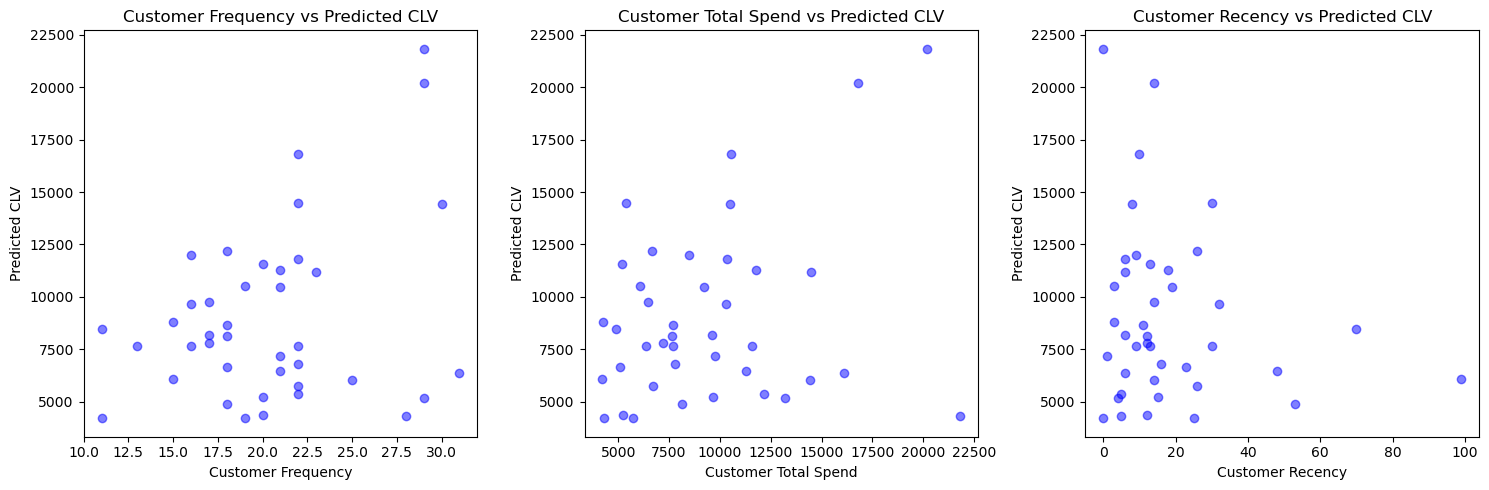

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

predictions = model.predict(X_scaled)  

customer_data_reset = customer_data.reset_index(drop=True)
X_train_reset = X_train.reset_index(drop=True)

train_data = customer_data_reset.loc[X_train_reset.index]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Now creating 3 subplots

# First scatter plot: Customer Frequency vs Predicted CLV
axes[0].scatter(train_data['Frequency'], predictions, alpha=0.5, color='blue')
axes[0].set_title('Customer Frequency vs Predicted CLV')
axes[0].set_xlabel('Customer Frequency')
axes[0].set_ylabel('Predicted CLV')

# Second scatter plot: Customer Total Spend vs Predicted CLV
axes[1].scatter(train_data['Total Spend'], predictions, alpha=0.5, color='blue')
axes[1].set_title('Customer Total Spend vs Predicted CLV')
axes[1].set_xlabel('Customer Total Spend')
axes[1].set_ylabel('Predicted CLV')

# Third scatter plot: Customer Recency vs Predicted CLV
axes[2].scatter(train_data['Recency'], predictions, alpha=0.5, color='blue')
axes[2].set_title('Customer Recency vs Predicted CLV')
axes[2].set_xlabel('Customer Recency')
axes[2].set_ylabel('Predicted CLV')

plt.tight_layout()
plt.show()


### Step 6: Save the Model for Future Use

Once the model has been trained and evaluated, we save it to a file using joblib. This allows us to reuse the model in the future without needing to retrain it. The model is saved as clv_model.pkl, which can later be loaded for predictions or further analysis.


In [7]:
import joblib
joblib.dump(model, 'clv_model.pkl')

['clv_model.pkl']

## Part 2: Usage

In [8]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler


model = joblib.load('clv_model.pkl')

# Prepare Sample new data for prediction, for 3 customers
new_data = pd.DataFrame({
    'Frequency': [10, 5, 20],  # Example: frequency of purchases for new customers
    'Monetary': [1500, 800, 2500],  # Example: monetary spend for new customers
    'Recency': [30, 90, 10],  # Example: recency in days for new customers
    'Customer Type': [1, 0, 2]  # Example: encoded customer types (e.g., 0, 1, 2 for different categories)
})


scaler = StandardScaler()
new_data_scaled = scaler.fit_transform(new_data)

#redict CLV (Total Spend) for new customers
predicted_clv = model.predict(new_data_scaled)


new_data['Predicted CLV'] = predicted_clv
new_data

,Frequency,Monetary,Recency,Customer Type,Predicted CLV
0,10,1500,30,1,8426.191378
1,5,800,90,0,4320.281021
2,20,2500,10,2,14291.777602


---
# Conclusion:

This predictive model offers significant benefits to retailers by allowing them to estimate the **Customer Lifetime Value (CLV)** for individual customers, which can be used to inform marketing strategies, customer retention plans, and resource allocation. By understanding which customers are likely to spend more over their lifetime, retailers can tailor personalized offers, loyalty programs, and targeted communications to enhance customer relationships. Furthermore, this model provides an opportunity to identify at-risk customers who might need re-engagement efforts, thus boosting retention rates. Automating this process with a pre-trained model can save valuable time and improve decision-making by leveraging data-driven insights to maximize customer value.

In practice, by incorporating such predictive models into daily operations, retailers can shift from reactive to proactive business strategies, increasing profitability and long-term customer loyalty.